## IAPR24: Coin Counter Project 
### Group 23

Here is how our project is structured
```code
├── main.ipynb
├── utils.py
├── neutral_array.pkl
├── neutral_hue.pkl
├── noisy_array.pkl
├── hand_array.pkl
├── hand_hue.pkl
└── data-coin-counter
        ├── ref
        │    ├── ref_chf.JPG
        │    └── ref_eur.JPG  
        ├── test
        └── train
            ├── 1. neutral_bg
            ├── 2. noisy_bg
            ├── 3. hand
            ├── 4. neutral_bg_outliers
            ├── 5. noisy_bg_outliers
            ├── 6. hand_outliers 
            └── train_labels.csv          
      


In [4]:
#!pip install torchvision

In [1]:
import os
import re
import copy 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader,  Dataset

from torchvision.models import resnet50
#ResNet50_Weights
import torch.nn.functional as F

from sklearn.metrics import f1_score

from collections import defaultdict
from typing import List, Tuple, Dict

from PIL import Image, ImageFilter
from skimage import filters
from typing import Callable
from skimage.color import rgb2yiq, rgb2hsv
from sklearn.model_selection import train_test_split

c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils import find_threshold, preprocessing, contours,cropped, radius

In [3]:
#As we have external function in a "utils.py" file, we need to reload it after any changes
%load_ext autoreload
%autoreload 2

In [4]:
current_path = os.getcwd()
print(current_path)
# add the pathdata
data_path_CHF = os.path.join(current_path, "data-coin-counter/ref/ref_chf.JPG")
data_path_EU = os.path.join(current_path, "data-coin-counter/ref/ref_eur.JPG")


#data_path = "/data/data_project/ref/ref_chf.JPG"
image_ref_CHF = Image.open(data_path_CHF)
image_ref_EU = Image.open(data_path_EU)

c:\Users\emy8\OneDrive\Documents\EPFL\Master\MA4\IAPR\IAPR_Lab


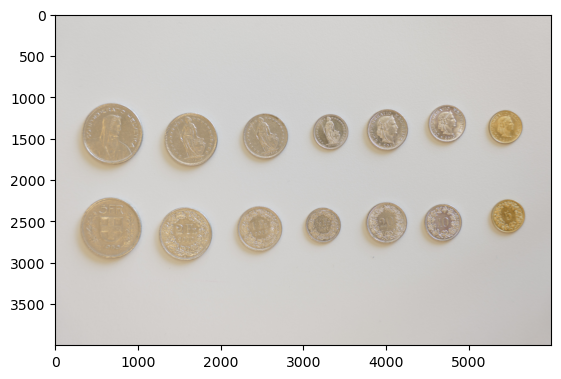

In [4]:
plt.imshow(image_ref_CHF)

In [ ]:
plt.imshow(image_ref_EU)

In [ ]:
find_threshold(image_ref_CHF)

## CHF coins

In [ ]:
image_postprocessing_CHF=preprocessing(image_ref_CHF)
plt.imshow(image_postprocessing_CHF, cmap="gray")

In [ ]:
contours_CHF=contours(image_postprocessing_CHF)
print(len(contours_CHF))

In [ ]:
for contour in contours_CHF:
    plt.plot(contour[:,0],contour[:,1], color = "red")
plt.imshow(image_ref_CHF)
plt.show()

In [ ]:
cropped_images_CHF,centroids_CHF=cropped(image_ref_CHF,contours_CHF)

In [ ]:
plt.imshow(cropped_images_CHF[13])

In [ ]:
print(centroids_CHF[13])

In [ ]:
labels=[1,6,5,7,2,3,4,8,14,12,13,10,9,11]
rads=radius(contours_CHF)

In [ ]:
for patches, centroid, r, label in zip(cropped_images_CHF,centroids_CHF,rads, labels):
    Image.fromarray(patches).save(f'data-coin-counter/ref/ref_chf_{centroid[0]}_{centroid[1]}_{r}_{label}.JPG', 'jpeg')
    #plt.imsave()

## € coins

In [ ]:
image_postprocessing_EU=preprocessing(image_ref_EU)
plt.imshow(image_postprocessing_EU, cmap="gray")

In [ ]:
contours_EU=contours(image_postprocessing_EU)
print(len(contours_EU))

In [ ]:
for contour in contours_EU:
    plt.plot(contour[:,0],contour[:,1], color = "red")
plt.imshow(image_ref_EU)
plt.show()

In [ ]:
cropped_images_EU,centroid_EU=cropped(image_ref_EU,contours_EU)


In [ ]:
plt.imshow(cropped_images_EU[7])

In [ ]:
labels_EU=[3,1,4,2,5,6,7,8]
rads_EU=radius(contours_EU)

In [ ]:
for cro, cent, radi, label in zip(cropped_images_EU,centroid_EU,rads_EU, labels):
    Image.fromarray(cro).save(f'data-coin-counter/ref/ref_eu_{cent[0]}_{cent[1]}_{radi}_{label}.JPG', 'jpeg')
    

## Generate image patches 

In [11]:
from utils import load_data_generate_patches

In [12]:
base = "data-coin-counter/train"

#where we put the patches
new_folder_name = "Patches"

new_folder_path = os.path.join(base, new_folder_name)

# Check if the folder already exists, if not, create it
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
    print(f"Folder '{new_folder_name}' created successfully at '{new_folder_path}'")
else:
    print(f"Folder '{new_folder_name}' already exists at '{new_folder_path}'")


Folder 'Patches' already exists at 'data-coin-counter/train\Patches'


In [42]:
# Neutral Background
subfolders_n=["1. neutral_bg","4. neutral_bg_outliers"]
load_data_generate_patches(base, subfolders_n, new_folder_name, 'neutral')

# Hand Background
subfolders_h = ["3. hand",  "6. hand_outliers"]
load_data_generate_patches(base, subfolders_h, new_folder_name, 'hand')


    

path_in data-coin-counter/train\1. neutral_bg\L1010277.JPG
filename L1010277


c:\Users\emy8\OneDrive\Documents\EPFL\Master\MA4\IAPR\IAPR_Lab\utils.py:52: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  new = remove_small_holes(new, 500)


path_in data-coin-counter/train\1. neutral_bg\L1010279.JPG
filename L1010279
path_in data-coin-counter/train\1. neutral_bg\L1010281.JPG
filename L1010281
path_in data-coin-counter/train\1. neutral_bg\L1010283.JPG
filename L1010283
path_in data-coin-counter/train\1. neutral_bg\L1010287.JPG
filename L1010287
path_in data-coin-counter/train\1. neutral_bg\L1010288.JPG
filename L1010288


KeyboardInterrupt: 

path_in data-coin-counter/train\5.2 noisy_bg_outliers\L1010487.JPG
filename L1010487
path_in data-coin-counter/train\5.2 noisy_bg_outliers\L1010491.JPG
filename L1010491
path_in data-coin-counter/train\5.2 noisy_bg_outliers\L1010500.JPG
filename L1010500
path_in data-coin-counter/train\5.2 noisy_bg_outliers\L1010501.JPG
filename L1010501
path_in data-coin-counter/train\5.2 noisy_bg_outliers\L1010503.JPG
filename L1010503


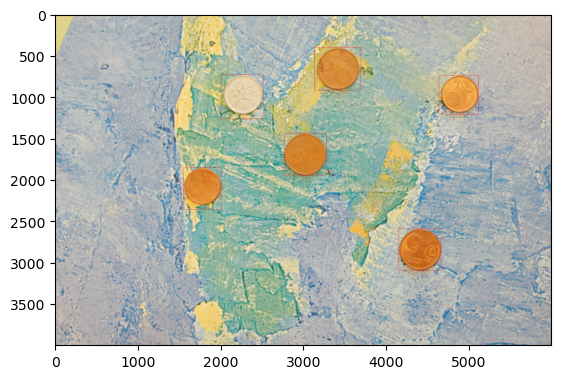

In [14]:
# Noisy Background
#subfolders_y = ["2. noisy_bg",  "5. noisy_bg_outliers"]
subfolders_y = ["5.2 noisy_bg_outliers"]
load_data_generate_patches(base, subfolders_y, new_folder_name, 'noisy')

### Hand background

In [10]:

# for sub in subfolders:
#     path=os.path.join(base,sub)
#     files= os.listdir(path)
#     for filename in files:
#         print('path_in',os.path.join(path,filename))
#         print('filename',filename.split('.',2)[0])
#         compute_patches_hand(path_in=os.path.join(path,filename), save_dir=os.path.join(base,"Patches"),
#                      name_image=filename.split('.',2)[0], subfolder=sub)

path_in data-coin-counter/train\3. hand\L1010373.JPG
filename L1010373
path_in data-coin-counter/train\3. hand\L1010375.JPG
filename L1010375
path_in data-coin-counter/train\3. hand\L1010377.JPG
filename L1010377
path_in data-coin-counter/train\3. hand\L1010378.JPG
filename L1010378
path_in data-coin-counter/train\3. hand\L1010382.JPG
filename L1010382
path_in data-coin-counter/train\3. hand\L1010383.JPG
filename L1010383
path_in data-coin-counter/train\3. hand\L1010388.JPG
filename L1010388
path_in data-coin-counter/train\3. hand\L1010390.JPG
filename L1010390
path_in data-coin-counter/train\3. hand\L1010391.JPG
filename L1010391
path_in data-coin-counter/train\3. hand\L1010395.JPG
filename L1010395
path_in data-coin-counter/train\6. hand_outliers\L1010506.JPG
filename L1010506
path_in data-coin-counter/train\6. hand_outliers\L1010510.JPG
filename L1010510
path_in data-coin-counter/train\6. hand_outliers\L1010515.JPG
filename L1010515
path_in data-coin-counter/train\6. hand_outliers\L

### Noisy background

In [102]:
from glob import glob
from utils import extract_background_info

In [103]:
input_path = os.path.join(current_path, "data-coin-counter/train/1. neutral_bg")
images_neutral_bg = glob(os.path.join(input_path, "*.JPG"))
input_path = os.path.join(current_path, "data-coin-counter/train/4. neutral_bg_outliers")
images_neutral_bg_outliers = glob(os.path.join(input_path, "*.JPG"))

images_neutral = images_neutral_bg + images_neutral_bg_outliers

In [104]:
input_path = os.path.join(current_path, "data-coin-counter/train/2. noisy_bg")
images_noisy_bg = glob(os.path.join(input_path, "*.JPG"))
input_path = os.path.join(current_path, "data-coin-counter/train/5. noisy_bg_outliers")
images_noisy_bg_outliers = glob(os.path.join(input_path, "*.JPG"))

images_noisy = images_noisy_bg + images_noisy_bg_outliers

In [105]:
input_path = os.path.join(current_path, "data-coin-counter/train/3. hand")
images_hand_bg = glob(os.path.join(input_path, "*.JPG"))
input_path = os.path.join(current_path, "data-coin-counter/train/6. hand_outliers")
images_hand_bg_outliers = glob(os.path.join(input_path, "*.JPG"))

images_hand = images_hand_bg + images_hand_bg_outliers

In [11]:
# save pickle files need to run it only once
extract_background_info(images_neutral,images_noisy,images_hand)

c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Check preprocessing

In [106]:
from utils import noisy_bg_crop, check_hand

In [ ]:
#check preprocessing
sub = "1. neutral_bg"
base = "data-coin-counter/train"
path=os.path.join(base,sub)
files= os.listdir(path)

for filename in files:
    img=Image.open(os.path.join(path,filename))
    image_postprocessin=preprocessing(img)

    co=contours(image_postprocessin)
    print("filename: ", filename)

    for c in co:
        plt.plot(c[:,0],c[:,1], color = "red")
    plt.imshow(img)
    plt.show()

In [ ]:
sub = "4. neutral_bg_outliers"
base = "data-coin-counter/train"
path=os.path.join(base,sub)
files= os.listdir(path)

for filename in files:
    if (filename!= ".ipynb_checkpoints"):
        img=Image.open(os.path.join(path,filename))
        image_postprocessing=preprocessing(img)
        conto=contours(image_postprocessing)
        print("filename: ", filename)
        for cont in conto:
            plt.plot(cont[:,0],cont[:,1], color = "red")
        plt.imshow(img)
        plt.show()


In [ ]:
subfolders= ["2. noisy_bg",  "5. noisy_bg_outliers"]
base = "data-coin-counter/train"
for sub in subfolders:
    path = os.path.join(base, sub)
    files = os.listdir(path)
    for filename in files:
        print("filename", filename)
        cropped_images, centroids,r=noisy_bg_crop(Image.open(os.path.join(path, filename)))
        plt.show()

In [ ]:
subfolders= ["3. hand",  "6. hand_outliers"]
base = "data-coin-counter/train"
for sub in subfolders:
    path = os.path.join(base, sub)
    files = os.listdir(path)
    for filename in files:
        check_hand(os.path.join(path, filename), filename)

## Test Data extraction

In [5]:
from utils import background_classifier,compute_patches_hand_mai,compute_patches_noisy, generate_patches

In [6]:
base = "data-coin-counter/test"
path = os.path.join(base)
files = os.listdir(path)

filename L0000046.JPG
filename L0000047.JPG
filename L0000048.JPG
filename L0000049.JPG
filename L0000050.JPG
filename L0000051.JPG
filename L0000052.JPG
filename L0000053.JPG
filename L0000054.JPG
filename L0000055.JPG
filename L0000056.JPG
filename L0000057.JPG
filename L0000058.JPG
filename L0000059.JPG
filename L0000060.JPG
filename L0000061.JPG
filename L0000062.JPG
filename L0000063.JPG
filename L0000064.JPG
filename L0000065.JPG
filename L0000066.JPG
filename L0000067.JPG
filename L0000068.JPG
filename L0000069.JPG
filename L0000070.JPG
filename L0000071.JPG
filename L0000072.JPG
filename L0000073.JPG
filename L0000074.JPG
filename L0000075.JPG
filename L0000076.JPG
filename L0000077.JPG
filename L0000078.JPG
filename L0000079.JPG
filename L0000080.JPG
filename L0000081.JPG
filename L0000082.JPG
filename L0000083.JPG
filename L0000084.JPG
filename L0000085.JPG
filename L0000086.JPG
filename L0000087.JPG
filename L0000088.JPG
filename L0000089.JPG
filename L0000090.JPG
filename L

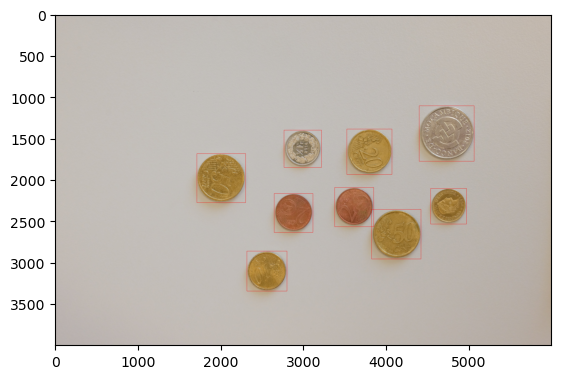

In [10]:
# Background classifier
for filename in files[47:]: 
    print("filename", filename)
    img = Image.open(os.path.join(path, filename))
    background = background_classifier(img)
    if background == 0:
        generate_patches(os.path.join(path, filename), os.path.join(path, 'extracted'), filename.split('.', 2)[0],'neutral')
    elif background == 1:
        compute_patches_noisy(os.path.join(path, filename), os.path.join(path, 'extracted'),filename.split('.', 2)[0],'noisy')
    elif background == 2:
        compute_patches_hand_mai(os.path.join(path, filename), os.path.join(path, 'extracted'), filename.split('.', 2)[0],'hand')


## Features extractions 

#### include QIY also?

In [16]:
from utils import features_extraction_classification

In [38]:
base = "data-coin-counter/train"
# Where we extract the patches
new_folder_name = "Patches"

# Create the dataset of features
features_dataset = features_extraction_classification(base, new_folder_name, True)

In [36]:
# do for the test set
base = "data-coin-counter/test"
#where we extract the patches
new_folder_name = "extracted"

# create the dataset of features
features_dataset_test = features_extraction_classification(base, new_folder_name, False)

In [39]:
features_dataset

,Image_label,coin_label,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std,Texture
0,L1010277,1,386.376678,190.419282,178.731785,162.570386,20.698642,26.823210,37.548491,0.118677,0.157578,0.747230,0.135014,0.121002,0.081383,3577.144531
1,L1010294,1,391.021179,182.635260,171.452913,156.791611,24.303428,29.917596,38.986449,0.107779,0.154708,0.716462,0.114412,0.114486,0.095482,3663.812500
2,L1010318,1,329.498566,187.845906,174.168044,155.784907,18.048302,25.146448,36.176015,0.098269,0.180892,0.736713,0.066680,0.122725,0.070810,3690.546875
3,L1010349,1,412.659302,172.306394,165.642077,144.388157,46.023548,29.051087,47.797892,0.330387,0.342892,0.750588,0.245002,0.202818,0.110224,3824.261719
4,L1010369,1,434.648254,203.284416,183.896462,141.001607,26.492516,21.986950,38.663418,0.209292,0.318845,0.809345,0.174553,0.204448,0.088873,4012.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,L1010523,8,401.103166,195.725547,165.038195,146.917454,14.830890,22.513752,22.882216,0.161135,0.253485,0.767560,0.278079,0.088348,0.058176,3929.722656
228,L1010321,9,289.914734,197.523316,182.591732,159.796243,13.901112,22.201847,40.341591,0.094099,0.197892,0.774616,0.037541,0.169572,0.054509,2315.625000
229,L1010321,9,293.173462,193.530698,181.248804,162.403866,17.078627,24.069572,38.636125,0.094908,0.169615,0.758971,0.046414,0.145444,0.067014,2348.703125
230,L1010323,9,313.775146,182.511978,170.213335,149.372485,18.003554,26.248226,44.090405,0.107892,0.194176,0.715794,0.061733,0.184925,0.070618,2483.968750


In [35]:
features_dataset_test

,Image_label,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std,Texture
0,L0000000,330.437408,184.426447,141.344174,117.121978,22.138912,32.393642,31.054646,0.159192,0.378258,0.723308,0.276213,0.119722,0.086805,2835.558594
1,L0000000,271.828156,174.713882,129.763763,110.123143,22.615337,18.283524,26.900504,0.166423,0.379881,0.685163,0.295140,0.085732,0.088697,2021.125000
2,L0000000,279.708069,189.599614,153.685811,136.917767,13.812692,24.573667,30.192395,0.241398,0.289578,0.743528,0.354436,0.113215,0.054167,2064.531250
3,L0000001,449.743073,196.768086,186.156852,171.280104,17.206321,23.538681,34.140893,0.104802,0.137607,0.771805,0.096144,0.113196,0.067483,1985.800781
4,L0000001,290.493561,200.239913,185.406649,161.967113,12.944624,22.197437,41.916743,0.098166,0.198456,0.785314,0.047303,0.175290,0.050728,2295.007812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,L0000043,243.008392,174.933810,149.964339,132.881370,17.875759,41.315645,53.619809,0.083496,0.264266,0.686025,0.076270,0.250944,0.070097,1753.480469
225,L0000043,271.101624,172.751496,148.477434,126.993551,19.005121,40.710695,58.141231,0.087484,0.293577,0.677476,0.067183,0.277008,0.074530,2067.382812
226,L0000044,219.813782,171.760517,179.286731,140.888233,46.496366,23.459605,33.156776,0.272243,0.319933,0.755125,0.147219,0.152665,0.116429,1525.875000
227,L0000044,269.148956,179.889029,174.772361,115.395884,50.816566,26.395334,46.966986,0.214511,0.442041,0.767172,0.127816,0.227947,0.123250,2055.890625


In [44]:
# Not needed as patches are already extracted

set = np.unique(features_dataset['Image_label'])[1]
#extract the features of the image with the label set
raw_data = features_dataset[features_dataset['Image_label']==set]
#Load the probabilistic labels
labels = pd.read_csv("data-coin-counter/train/true_labels.csv")
#insert the labels in the features dataset corresponding to the image
labels_id = labels[labels["id"].isin(raw_data["Image_label"])]
#select the labels corresponding to the images in the features dataset
labels = labels[labels["id"].isin(features_dataset["Image_label"])]
labels

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L1010281,0.000000,0.000000,0.000000,0.000000,0.25,0.375000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
1,L1010298,0.000000,0.400000,0.200000,0.400000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,L1010321,0.000000,0.000000,0.111111,0.222222,0.00,0.000000,0.000000,0.111111,0.222222,0.000000,0.222222,0.111111,0.000000,0.000000,0.000000,0.000000
3,L1010310,0.000000,0.000000,0.142857,0.142857,0.00,0.000000,0.142857,0.285714,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000
4,L1010300,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
5,L1010323,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.000000
6,L1010277,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
7,L1010294,0.200000,0.000000,0.200000,0.000000,0.00,0.200000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
8,L1010287,0.000000,0.125000,0.125000,0.000000,0.00,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.250000,0.125000,0.125000,0.125000,0.000000
9,L1010308,0.111111,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.111111,0.000000,0.000000,0.222222,0.111111,0.222222,0.222222,0.000000,0.000000


### PCA 

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [10]:
data_set = features_dataset.drop(columns=['Image_label'])
data_set = data_set.drop(columns=['coin_label'])
labels = features_dataset['coin_label']
data_set

,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std,Texture
0,386.376678,190.419282,178.731785,162.570386,20.698642,26.823210,37.548491,0.118677,0.157578,0.747230,0.135014,0.121002,0.081383,3577.144531
1,391.021179,182.635260,171.452913,156.791611,24.303428,29.917596,38.986449,0.107779,0.154708,0.716462,0.114412,0.114486,0.095482,3663.812500
2,329.498566,187.845906,174.168044,155.784907,18.048302,25.146448,36.176015,0.098269,0.180892,0.736713,0.066680,0.122725,0.070810,3690.546875
3,412.659302,172.306394,165.642077,144.388157,46.023548,29.051087,47.797892,0.330387,0.342892,0.750588,0.245002,0.202818,0.110224,3824.261719
4,434.648254,203.284416,183.896462,141.001607,26.492516,21.986950,38.663418,0.209292,0.318845,0.809345,0.174553,0.204448,0.088873,4012.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,401.103166,195.725547,165.038195,146.917454,14.830890,22.513752,22.882216,0.161135,0.253485,0.767560,0.278079,0.088348,0.058176,3929.722656
228,289.914734,197.523316,182.591732,159.796243,13.901112,22.201847,40.341591,0.094099,0.197892,0.774616,0.037541,0.169572,0.054509,2315.625000
229,293.173462,193.530698,181.248804,162.403866,17.078627,24.069572,38.636125,0.094908,0.169615,0.758971,0.046414,0.145444,0.067014,2348.703125
230,313.775146,182.511978,170.213335,149.372485,18.003554,26.248226,44.090405,0.107892,0.194176,0.715794,0.061733,0.184925,0.070618,2483.968750


In [11]:
x = data_set.values
x = StandardScaler().fit_transform(x) # normalizing the features as the PCA is sensible to it

In [16]:
# check the mean is at 0 and the std at 1
np.mean(x),np.std(x)

(6.781657884409824e-17, 1.0)

In [19]:
pca_feat = PCA(n_components=2)
principalComponents_feat = pca_feat.fit_transform(x)
principal_feat_Df = pd.DataFrame(data = principalComponents_feat
             , columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca_feat.explained_variance_ratio_))

Explained variation per principal component: [0.28788872 0.21363931]


In [20]:
principal_Df = pd.DataFrame(data = principalComponents_feat
             , columns = ['principal component 1', 'principal component 2'])
principal_Df['y'] = labels
principal_Df['y'] = pd.Categorical(principal_Df['y'], 
                                   categories=sorted(principal_Df['y'].unique(), key=int))

<Axes: xlabel='principal component 1', ylabel='principal component 2'>

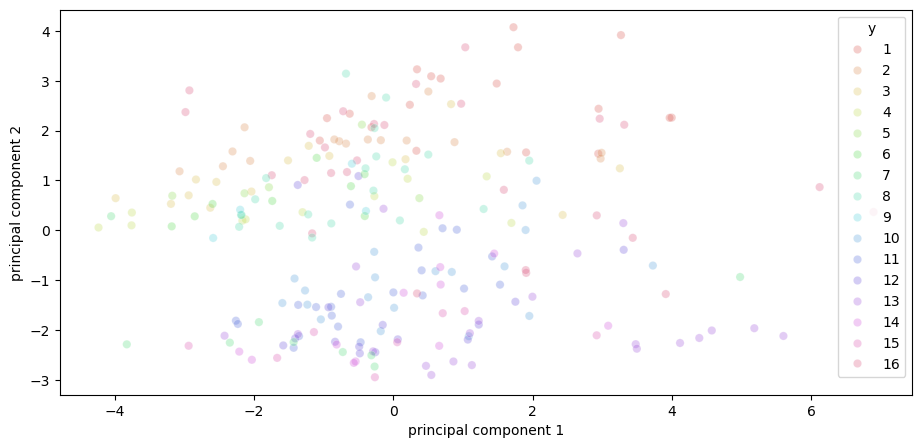

In [21]:
plt.figure(figsize=(11,5))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 16),
    data=principal_Df,
    legend="full",
    alpha=0.3
)

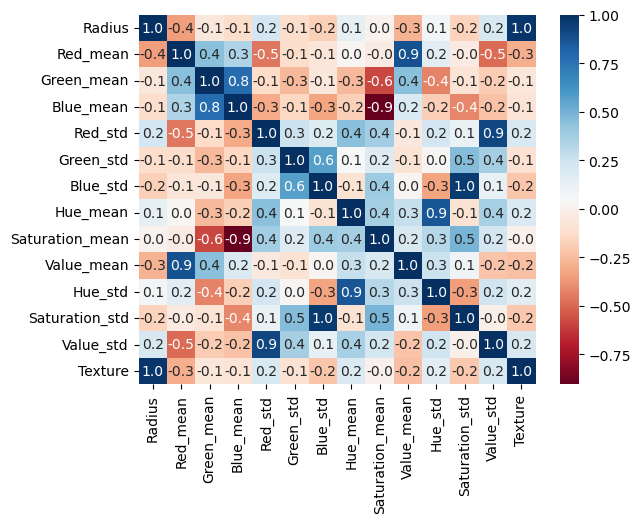

In [22]:
sns.heatmap(data_set.corr(), annot=True,
           cbar=True, cmap='RdBu', fmt='.1f')
plt.savefig('heatmap.png')
plt.show()

We don't want to see a too high correlation between the features (correlation greater than 0.8) in the dataset, as it can lead to data leakage or unnecessary increased complexity of the model. 

## Classification

In [35]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
import platform
# Get os name
os_name = platform.system().lower()
num_workers = 8
# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    #%pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    #%pip install torch==1.8.1+cpu torchvision==0.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users

Detected Windows


### Split the dataset in train & Validation

In [46]:
#split features_dataset with 70% for training and 30% for testing
labels = features_dataset['coin_label']
X = features_dataset.drop(columns=['Image_label'])
X = X.drop(columns=['coin_label'])
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=labels)
#change the labels to numerical values
# change the y labels, now starting from 0 to 15 and not 1 to 16
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

In [47]:
X_train

,Radius,Red_mean,Green_mean,Blue_mean,Red_std,Green_std,Blue_std,Hue_mean,Saturation_mean,Value_mean,Hue_std,Saturation_std,Value_std,Texture
6,517.993586,192.817585,153.019090,139.407799,21.900508,35.099866,42.544454,0.334556,0.304271,0.756195,0.407941,0.160160,0.085937,5957.910156
70,274.938690,178.542859,162.370150,134.264222,17.984106,31.620427,59.863859,0.100121,0.274626,0.700185,0.034791,0.291033,0.070526,2072.578125
66,267.660309,186.964023,171.973869,144.356964,12.177418,24.646652,53.195156,0.104162,0.240003,0.733221,0.038954,0.256112,0.047754,1980.109375
146,336.455505,194.799681,183.250111,167.336015,17.352535,23.348185,34.156742,0.110726,0.149539,0.764415,0.113971,0.117709,0.068072,2891.812500
92,291.214691,181.895004,154.528930,136.792004,15.541446,40.716520,55.257567,0.084174,0.264636,0.713333,0.087336,0.268368,0.060933,2220.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,223.785873,188.882644,179.534915,167.795104,26.144899,30.605930,38.442895,0.115486,0.124564,0.741354,0.141122,0.116125,0.102248,1609.980469
100,253.661377,192.329080,164.313416,146.270562,11.128290,35.983323,51.456441,0.083047,0.244517,0.754238,0.069829,0.256249,0.043632,1859.625000
231,220.411087,189.249565,165.536509,157.018994,14.895019,27.786210,32.434522,0.305361,0.192569,0.742999,0.364986,0.133125,0.058848,2732.812500
228,289.914734,197.523316,182.591732,159.796243,13.901112,22.201847,40.341591,0.094099,0.197892,0.774616,0.037541,0.169572,0.054509,2315.625000


In [58]:
# When patches were not labeled

# split the features_dataset in train and validation dataset with DataLoader
name_images = np.unique(features_dataset['Image_label'])

#70% training vs 30% validation
split_index = int(len(name_images) * 0.7)
train_array = name_images[:split_index]
validation_array = name_images[split_index:]

train_dataset = features_dataset[features_dataset['Image_label'].isin(train_array)]
#select the label in the training set, ! not the same order !
labels_train = labels[labels["id"].isin(train_array)]
# need to make the same size, repeat the labels by the number of rows for a given image 'Image_label'
# look how many times the image is repeated
repeated = train_dataset['Image_label'].value_counts()
# repeat the labels
labels_train = labels_train.loc[labels_train.index.repeat(repeated.values)]


validation_dataset = features_dataset[features_dataset['Image_label'].isin(validation_array)]
labels_validation = labels[labels["id"].isin(validation_array)]


print(len(train_dataset))
print(len(validation_dataset))
print(len(features_dataset))
print(len(labels_train))
print(train_dataset['Image_label'].unique())
print(labels_train['id'].unique())
print(labels_train)


KeyError: 'id'

#### How to combine the rows for one image to match the labels ?

do a prediction for each coin [0.85 0 0 0 0 ...]  (softmax) --> sum the prediction of each coin (soft max devrait mettre vers 1 dans une catégorie quand sûr) et compare avec le true label (loss MAE ou MSE à voir comment on sum qd bcp de pièce de 1 type, peut etre diviser par qqch)

### For model with our extracted features

#### when patches were not labeled

In [ ]:
class Coins_IMG(Dataset):
    """Coins dataset using 15 classes"""

    def __init__(self, dataframe_train, dataframe_label) -> None:
        """
        Attributes:
            raw_data (dataframe): (M) List of M slides raw data as dictionaries. 
            train (bool): True if data are the training set. False otherwise
            
        Args:
            features_path (str): The path to the features file
            train (bool): Whether it is the training dataset or not
        """
        
        super().__init__()
        # Load raw data from path
        self.raw_data = dataframe_train
        self.label_set = dataframe_label
        # Set if training or not
        #self.train = train

    def __len__(self) -> int:
        """Returns the length of the dataset (images)

        Returns:
            int: The length M of the dataset (nb of images)
        """

        n_data = 0 
        n_data = len(np.unique(self.raw_data['Image_label']))
        
        return n_data
    
    def __getitem__(self, index : int):
        """Returns the entry at index from the dataset

        Args:
            index (int): the requested entry index of the dataset (image index)

        Returns:
            features (torch.Tensor): (N, d) Feature tensor of the selected slide with N patches and d feature dimensions
            label (int): Ground truth label {0, ..., n_classes} of a image
            wsi_id (str): Name of the WSI as "DHMC_xxx" where xxx is a unique id of the slide (train == False only)
            coordinates (torch.Tensor): (N, 2) xy coordinates of the N patches of the selected slide (train == False only)
        """

        features = None
        label = None
        #wsi_id = None
        #coordinates = None
    
        set = np.unique(features_dataset['Image_label'])[index]
        #extract the features of the image with the label set
        raw_data = features_dataset[features_dataset['Image_label']==set]
        #extract features from this image
        features_t = raw_data.drop(columns=['Image_label'])
        features= features_t.astype(float)
        features = torch.tensor(np.array(features))
        label_raw = self.label_set[self.label_set["id"].isin(raw_data["Image_label"])]
        label_wth_id = label_raw.drop(columns=['id'])
        label = torch.tensor(np.array(label_wth_id))
        
        return features, label

### When patches are labeled

In [75]:
class Coins_IMG_labeled(Dataset):
    """Coins dataset using 15 classes"""

    def __init__(self, dataframe_train, dataframe_label) -> None:
        """
        Attributes:
            raw_data (dataframe): (M) List of M slides raw data as dictionaries. 
            train (bool): True if data are the training set. False otherwise
            
        Args:
            features_path (str): The path to the features file
            train (bool): Whether it is the training dataset or not
        """
        
        super().__init__()
        # Load raw data from path
        self.raw_data = dataframe_train
        self.label_set = dataframe_label
        # Set if training or not
        #self.train = train

    def __len__(self) -> int:
        """Returns the length of the dataset (images)

        Returns:
            int: The length M of the dataset (nb of images)
        """

        n_data = 0 
        n_data = len(self.raw_data)
        
        return n_data
    
    def __getitem__(self, index : int):
        """Returns the entry at index from the dataset

        Args:
            index (int): the requested entry index of the dataset (image index)

        Returns:
            features (torch.Tensor): (N, d) Feature tensor of the selected slide with N patches and d feature dimensions
            label (int): Ground truth label {0, ..., n_classes} of a image
            wsi_id (str): Name of the WSI as "DHMC_xxx" where xxx is a unique id of the slide (train == False only)
            coordinates (torch.Tensor): (N, 2) xy coordinates of the N patches of the selected slide (train == False only)
        """

        features = None
        label = None
        #wsi_id = None
        #coordinates = None
    
        features_t = self.raw_data.iloc[index]
        features= features_t.astype(float)
        features = torch.tensor(np.array(features))

        label_t = self.label_set.iloc[index]
        label = float(label_t)
        label = torch.tensor(np.array(label_t))
        

        return features, label

In [76]:
X_train_dataset = Coins_IMG_labeled(X_train, y_train)
X_val_dataset = Coins_IMG_labeled(X_val, y_val)

train_loader = DataLoader(X_train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(X_val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

In [ ]:
# When patches not labeled
train_dataset = Coins_IMG(train_dataset,labels_train)
val_dataset = Coins_IMG(validation_dataset,labels_validation)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

### Linear Classifier

The aim of this model is to use it with the general label of a picture, i.e without the labels manually extracted

In [149]:
from utils import cross_entropy_pooling, calculate_ranking_score
from sklearn.metrics import f1_score as f1

In [84]:
class AveragePooling(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, features : torch.Tensor):
        
        if features.dim() == 1:
            return features

        mean = None
        
        mean = torch.mean(features, dim=0, keepdim=True)
        
        return mean

In [85]:
class LinearClassifier(nn.Module):

    def __init__(self, in_dim : int, H : int, n_classes : int, pooling_fn : nn.Module) -> None:

        super().__init__()

        proj_layer = None
        pool_layer = None
        fc_layer = None
        

        proj_layer = nn.Linear(in_dim, H)
        pool_layer = pooling_fn
        fc_layer = nn.Linear(H, n_classes)


        self.proj = proj_layer
        self.pool = pool_layer
        self.fc = fc_layer
        

    def forward(self, x):

        y = None

        x = np.squeeze(x)
        x = self.proj(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x= self.fc(x)
        y=nn.functional.relu(x)

        return y
     

In [86]:
@torch.no_grad()
def test(model : nn.Module, test_loader : DataLoader):

    model.eval()

    preds_dict = {"preds" : torch.Tensor(), "labels" : torch.Tensor(), 'losses': torch.Tensor()}
    for features, labels in test_loader:
        
        print("labels", labels)
        features = features.float()

        # Forward 
        preds = model(features)
        
        #compute loss
        loss = cross_entropy_pooling(labels, preds)
        

        # Store values
        preds_dict["preds"] = torch.cat([preds_dict["preds"], preds])
        preds_dict["labels"] = torch.cat([preds_dict["labels"], labels])
        preds_dict["losses"] = torch.cat([preds_dict["losses"], loss[None]])

    # Compute metric and loss
    ranking =calculate_ranking_score(preds_dict["labels"],preds_dict["preds"]) 
    loss = preds_dict["losses"].mean()

    return ranking, loss

In [87]:
def train(model : nn.Module, train_loader : DataLoader, val_loader : DataLoader, n_epochs : int, optimizer : torch.optim.Optimizer):

    # Initialize variable to return
    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []


    for epoch in range(n_epochs):
        model.train()
        loss_t = 0
        for features, labels in train_loader:
            # Dont keep track of the gradients
            optimizer.zero_grad()
            label=labels[0,0,:]
            features = features.float()

            # Forward 
            preds = model(features)
        
            #compute loss
            loss = cross_entropy_pooling(label, preds)
            
            loss.backward()
            optimizer.step()
            # take the mean to get corresponding shape with the validation loss
            loss_t = loss_t + loss.item()
              
        train_losses.append(loss_t/len(train_loader))
        ranking, val_loss = test(model, val_loader)
        val_f1s.append(ranking)
        val_losses.append(val_loss)
        if f1 > best_f1:
            best_f1 = f1
            # range() starts at 0 to epoch-1
            best_epoch = epoch+1
            # Need to return the best model
            best_model = copy.deepcopy(model.state_dict())

    
    return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

In [150]:
# Set seed for reproducibility
torch.manual_seed(0)

# Display loss progression and f1 score
epochs = 30
d, H, n_classes = 13, 7, 16

# Create Linear classifier and optimizer
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AveragePooling()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training and display results
_, best_f1, best_epoch, val_accs, val_loss, train_loss = train(model, train_loader, val_loader, n_epochs=epochs, optimizer=optimizer)
print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

IndexError: too many indices for tensor of dimension 1

In [ ]:
def plot_training(best_epoch: int, val_accs: list, val_loss: list, train_loss: list):
    """Plot training results of linear classifier
    
    Args:
        best_epoch (int): Best epoch
        val_accs (List): (E,) list of validation measures for each epoch
        val_loss (List): (E,) List of validation losses for each epoch
        train_loss (List): (E,) List of training losses for each epoch
    """

    # Create plot
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    es = np.arange(1, len(val_accs)+1)
    # Plot F1 score
    axes[0].plot(es, val_accs, label="Val")
    axes[0].vlines(best_epoch, ymin=np.min(val_accs), ymax=np.max(val_accs), color='k', ls='--', label="Best epoch")
    axes[0].set_xlabel("Training steps")
    axes[0].set_ylabel("F1-score")
    axes[0].set_title("F1-score")
    axes[0].legend()

    # Plot losses
    axes[1].plot(es, val_loss, label="Val")
    axes[1].plot(es, train_loss, label="Train")
    axes[1].vlines(best_epoch, ymin=np.min(train_loss), ymax=np.max(val_loss), color='k', ls='--', label="Best epoch")
    axes[1].set_xlabel("Training steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Losses")
    axes[1].legend()
    
    plt.tight_layout()

# Plot results
plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)

### Gradient Boosting Classifier

The aim of this model is to use it with the features extracted for each patch. Is uses the manually extracted labels

In [40]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, log_loss,classification_report
from utils import submission
from sklearn.model_selection import GridSearchCV

In [41]:
# # Potential parameters to look for tuning

# params = {
#     'objective': 'multiclass',
#     'num_class': 16,
#     'num_leaves': 5,                # Further reduced number of leaves
#     'min_data_in_leaf': 10,         # Further increased minimum data in leaf
#     'lambda_l1': 2.0,               # Higher L1 regularization
#     'lambda_l2': 2.0,               # Higher L2 regularization
#     'learning_rate': 0.01,          # Lower learning rate
#     'metric': 'multi_logloss',      # Metric for multiclass classification
#     'bagging_fraction': 0.7,        # Use 70% of data for bagging
#     'bagging_freq': 5,              # Perform bagging every 5 iterations
#     'feature_fraction': 0.7,        # Use 70% of features
#     'verbose': -1
# }


In [42]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    return [('f1', f1_score(y_true, np.argmax(y_hat,axis=1),average='macro'), True), ('accuracy', accuracy_score(y_true, np.argmax(y_hat,axis=1)),True)]

### How to get the f1 score and accuracy on the full training?

In [13]:
param_grid = {
    'num_leaves': [ 6, 7, 8, 9],              # Adjust as needed
    'min_data_in_leaf': [1, 2, 3, 4],           # Adjust as needed
    'lambda_l1': [ 0.3, 0.4, 0.5, 0.6],             # Adjust as needed
    'lambda_l2': [0.3, 0.4, 0.5, 0.6, 0.7],             # Adjust as needed
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]        # Adjust as needed
}

In [14]:
# Initialise the model
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=16, metric='multi_logloss', verbose=-1)
# Di a grid search to determine hyperparameters
grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train)
# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best F1 score
print("Best F1 score found: ", grid_search.best_score_)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best parameters found:  {'lambda_l1': 0.6, 'lambda_l2': 0.5, 'learning_rate': 0.4, 'min_data_in_leaf': 3, 'num_leaves': 7}
Best F1 score found:  0.4252903983762229


In [43]:
# From Grid search
params = {
    'objective': 'multiclass',
    'num_class': 16,
    'num_leaves': 7,                # Reduced number of leaves
    'min_data_in_leaf': 3,           # Increased minimum data in leaf
    #'min_sum_hessian_in_leaf': 1e-3, # Small value to allow splits
    'lambda_l1': 0.6,                # L1 regularization
    'lambda_l2': 0.5,                # L2 regularization
    'learning_rate': 0.4,           # Lower learning rate
    'metric': ['multi_logloss'],        # Metric for multiclass classification
    'verbose': -1
}

In [50]:
# Create the dataset for LightGBM
dtrain = lgb.Dataset(X_train, label=y_train)
valid_sets = lgb.Dataset(X_val, label=y_val)


# Cross-validation to determine the best number of boosting rounds
cv_results = lgb.cv(
    params,
    dtrain,
    num_boost_round=400,
    nfold=5,
    stratified=True,
    shuffle=True,
    metrics='multi_logloss',
    seed=42
)         
    
best_num_boost_round = len(cv_results['valid multi_logloss-mean'])
dic_pred = {}

# Train the model on the entire training data with the best number of boosting rounds
bst = lgb.train(params, dtrain, num_boost_round=best_num_boost_round, valid_sets=[dtrain,valid_sets], feval=lgb_f1_score, callbacks=[lgb.early_stopping(stopping_rounds=20),
                                                                                                                                     lgb.record_evaluation(dic_pred)])
   
# Training loss (using the entire training set)
y_train_pred = bst.predict(X_train)
y_val_pred = bst.predict(X_val)

y_train_pred = np.argmax(y_train_pred, axis=1)
y_val_pred = np.argmax(y_val_pred, axis=1)

    

c:\Users\emy8\anaconda3\envs\iapr\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's multi_logloss: 0.163475	training's f1: 1	training's accuracy: 1	valid_1's multi_logloss: 1.4007	valid_1's f1: 0.580772	valid_1's accuracy: 0.614286


In [51]:
# Not the best way to estimate as might have unbalanced classes
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))
print('Training-set F1 score: {0:0.4f}'. format(f1_score(y_train, y_train_pred, average='macro')))
print('Validation-set accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_val_pred)))
print('Validation-set F1 score: {0:0.4f}'. format(f1_score(y_val, y_val_pred, average='macro')))

Training-set accuracy score: 1.0000
Training-set F1 score: 1.0000
Validation-set accuracy score: 0.6143
Validation-set F1 score: 0.5808


In [52]:
target_names = ['class 5CHF', 'class 2CHF', 'class 1CHF', 'class 0.5CHF', 'class 0.2CHF', 'class 0.1CHF', 'class 0.05CHF', 'class 2eu', 'class 1eu', 'class 0.5eu', 'class 0.2eu', 'class 0.1eu', 'class 0.05eu', 'class 0.02eu', 'class 0.01eu', 'class OoD']
print(classification_report(y_val, y_val_pred, target_names=target_names, zero_division=0))
# support is the number of coins in one category

               precision    recall  f1-score   support

   class 5CHF       0.67      0.80      0.73         5
   class 2CHF       0.50      0.33      0.40         6
   class 1CHF       0.50      0.67      0.57         6
 class 0.5CHF       0.50      0.60      0.55         5
 class 0.2CHF       0.86      0.86      0.86         7
 class 0.1CHF       0.50      0.25      0.33         4
class 0.05CHF       0.40      1.00      0.57         2
    class 2eu       0.50      0.62      0.56         8
    class 1eu       0.67      0.80      0.73         5
  class 0.5eu       1.00      0.40      0.57         5
  class 0.2eu       0.67      0.50      0.57         4
  class 0.1eu       0.50      1.00      0.67         1
 class 0.05eu       1.00      0.50      0.67         2
 class 0.02eu       1.00      0.67      0.80         3
 class 0.01eu       0.80      0.67      0.73         6
    class OoD       0.00      0.00      0.00         1

     accuracy                           0.61        70
    macr

In [53]:
print(classification_report(y_train, y_train_pred, target_names=target_names, zero_division=0))

               precision    recall  f1-score   support

   class 5CHF       1.00      1.00      1.00        13
   class 2CHF       1.00      1.00      1.00        13
   class 1CHF       1.00      1.00      1.00        15
 class 0.5CHF       1.00      1.00      1.00        10
 class 0.2CHF       1.00      1.00      1.00        15
 class 0.1CHF       1.00      1.00      1.00         8
class 0.05CHF       1.00      1.00      1.00         6
    class 2eu       1.00      1.00      1.00        19
    class 1eu       1.00      1.00      1.00        12
  class 0.5eu       1.00      1.00      1.00        10
  class 0.2eu       1.00      1.00      1.00         8
  class 0.1eu       1.00      1.00      1.00         4
 class 0.05eu       1.00      1.00      1.00         6
 class 0.02eu       1.00      1.00      1.00         6
 class 0.01eu       1.00      1.00      1.00        14
    class OoD       1.00      1.00      1.00         3

     accuracy                           1.00       162
    macr

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

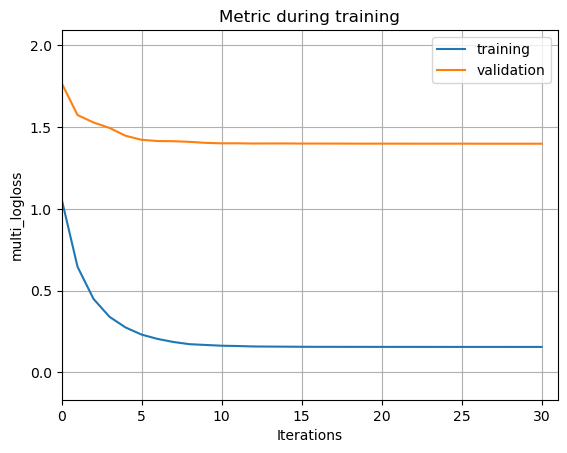

In [57]:
# change the name 'valid_0' to 'validation' for the plot
dic_pred['validation'] = dic_pred.pop('valid_1')

lgb.plot_metric(dic_pred, metric='multi_logloss')
# Compute the log loss, similar to the cross-entropy loss
# for the moment not working as dont classify all the classes
# logloss = log_loss(y_true = y_val, y_pred = y_val_pred)
# logloss_t = log_loss(y_train, y_train_pred)
# print('Achieved Validation Log loss:', logloss)
# print('Achieved Training Log loss:', logloss_t)

Achieved Validation F1 score: 0.5807720057720058
Achieved Training F1 score: 1.0


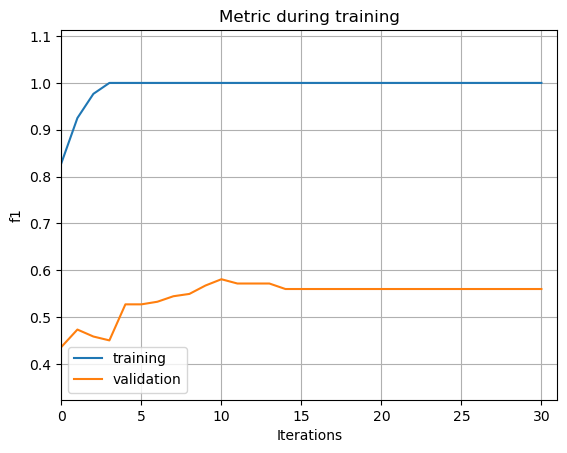

In [58]:
lgb.plot_metric(dic_pred, metric='f1')
# Compute the log loss, similar to the cross-entropy loss
F1_v = f1_score(y_val, y_val_pred, average='macro')
F1_t = f1_score(y_train, y_train_pred, average='macro')
print('Achieved Validation F1 score:', F1_v)
print('Achieved Training F1 score:', F1_t)

Achieved Validation Accuracy: 0.6142857142857143
Achieved Training Accuracy: 1.0


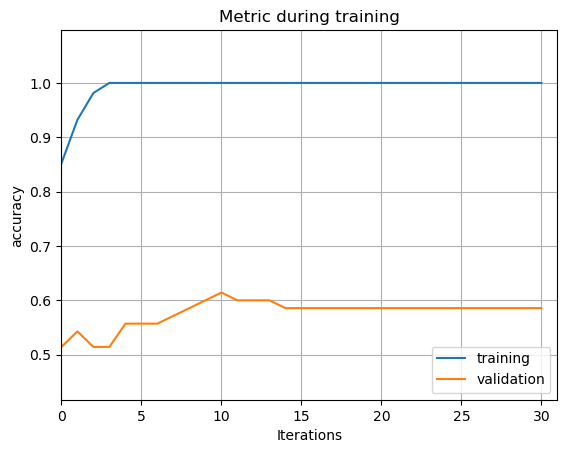

In [59]:
lgb.plot_metric(dic_pred, metric='accuracy')
# Compute the log loss, similar to the cross-entropy loss
accuracy_v = accuracy_score(y_val, y_val_pred)
accuracy_t = accuracy_score(y_train, y_train_pred)
print('Achieved Validation Accuracy:', accuracy_v)
print('Achieved Training Accuracy:', accuracy_t)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

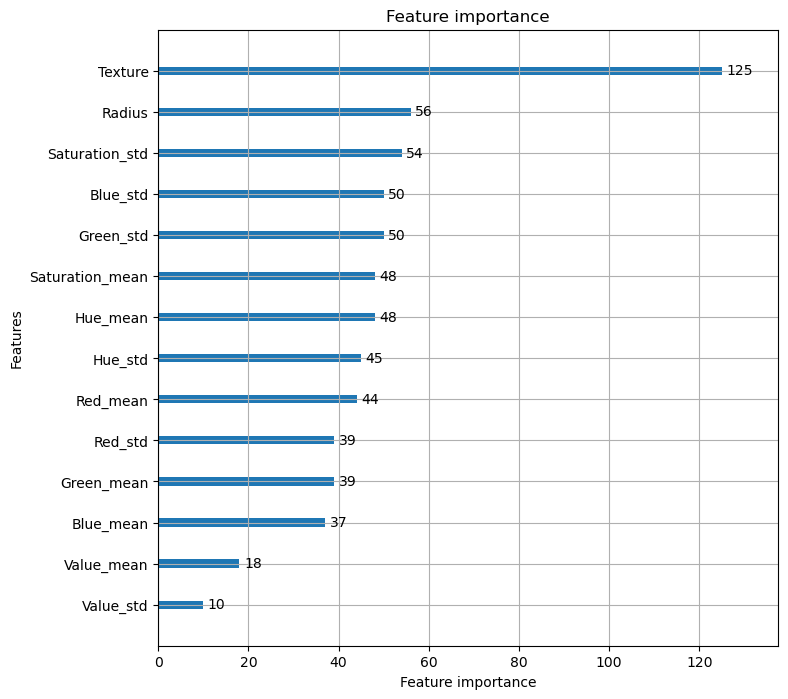

In [90]:
lgb.plot_importance(bst,figsize=(8,8))

In [92]:
test_data = features_dataset_test.drop(columns=['Image_label'])
images_id = features_dataset_test['Image_label']

y_test_pred = bst.predict(test_data)
y_test_pred = np.argmax(y_test_pred, axis=1)


In [99]:
# Dont know why but in function not working
id = ['id','5CHF','2CHF','1CHF','0.5CHF','0.2CHF','0.1CHF','0.05CHF','2EUR','1EUR','0.5EUR','0.2EUR','0.1EUR','0.05EUR','0.02EUR','0.01EUR','OOD']
submission_text = pd.DataFrame(columns=id)
submission_text['id'] = np.unique(images_id)
submission_text = submission_text.fillna(0)

#do a dict to map the coin to the index
coin_to_index = {'5CHF':0,'2CHF':1,'1CHF':2,'0.5CHF':3,'0.2CHF':4,'0.1CHF':5,'0.05CHF':6,'2EUR':7,'1EUR':8,'0.5EUR':9,'0.2EUR':10,'0.1EUR':11,'0.05EUR':12,'0.02EUR':13,'0.01EUR':14,'OOD':15}

for coin in range(len(y_test_pred)):
    image_name = images_id[coin]
    value = y_test_pred[coin]
    key = next(key for key, val in coin_to_index.items() if val == value)
    submission_text.loc[submission_text['id']==image_name,key] += 1

name = current_path + '/submission.csv'
submission_text.to_csv(name, index=False)
print(submission_text)

          id  5CHF  2CHF  1CHF  0.5CHF  0.2CHF  0.1CHF  0.05CHF  2EUR  1EUR  \
0   L0000000     0     0     0       0       0       0        0     1     1   
1   L0000001     0     1     0       0       1       0        0     0     1   
2   L0000002     1     0     0       0       1       1        0     0     0   
3   L0000003     0     0     0       1       0       0        0     3     0   
4   L0000004     0     0     0       0       0       1        0     0     0   
5   L0000005     0     0     0       0       0       1        0     0     0   
6   L0000006     0     0     0       0       0       0        0     3     2   
7   L0000007     0     0     0       0       0       0        0     4     1   
8   L0000008     0     1     0       0       0       0        0     2     1   
9   L0000009     0     0     0       0       0       0        0     0     0   
10  L0000010     0     0     0       0       0       0        0     3     0   
11  L0000011     1     0     1       0       0      

C:\Users\emy8\AppData\Local\Temp\ipykernel_1504\2941734154.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  submission_text = submission_text.fillna(0)


In [118]:
#add the image name to X_val
# y_val_pred = bst.predict(X_val)

# y_train_pred = np.argmax(y_train_pred, axis=1)
# X_val_t = X_val.copy()
# X_val_t['Image_label'] = features_dataset['Image_label'].iloc[X_val.index]


### Pre-trained Model 

#### Fine_tuned resnet

### Without additional labels

In [ ]:
# Set seed for reproducibility
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the imageNet pre-trained model on ILSVRC2012 (aka ImageNet-1K) of maximum 400MB
model = models.resnet50(pretrained=True).to(device)
#model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
num_classes = 16  # Number of coin types + 1 for out of distributions
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_classes)
).to(device)


In [ ]:
from utils import ImagePatchDataset,train_without_label
from utils import collate_fn

In [ ]:
base= "data-coin-counter/train"
root_dir = os.path.join(base, 'Patches')
root_true_label=os.path.join(base, 'train_labels.csv')

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dataset = ImagePatchDataset(root_dir,root_true_label, transform=transform)

# Check if dataset is loading correctly
print(f"Total groups: {len(dataset)}")


In [ ]:
# Split the dataset
train_dataset, val_dataset = dataset.train_val_split(val_ratio=0.2)
# Create DataLoaders for each dataset
batch_size = 1
train_ = DataLoader(train_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=True)
val_= DataLoader(val_dataset, batch_size=batch_size,collate_fn=collate_fn, shuffle=False)

for patches, labels, original_image in val_:
    # patches is a tensor containing all patches for the current original image
    # original_images is a list of original image identifiers (should be batch size 1 in this case)
    print(original_image)
    print("shapes of all the patches",patches.shape)
    print(labels)
    print(pd.read_csv(root_true_label, index_col=0).loc[original_image])
    break


In [ ]:
model_without_label=train_without_label(model, train_, val_, n_epochs=1)

### With Patches Labels: with freezing and without

In [ ]:
from utils import LabelledImagePatchDataset,train_with_label, plot_training


In [ ]:
# Set seed for reproducibility
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the imageNet pre-trained model on ILSVRC2012 (aka ImageNet-1K) of maximum 400MB
model = models.resnet50(pretrained=True).to(device)
#model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
num_classes = 16  # Number of coin types + 1 for out of distributions
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_classes),
    nn.BatchNorm1d(num_classes)
).to(device)

In [ ]:
# Usage example
base = "data-coin-counter/train"
root_patches_with_labels = os.path.join(base, 'Patches')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_labelled = LabelledImagePatchDataset(root_dir=root_patches_with_labels, transform=transform)
train_data, val_data = dataset_labelled.train_val_split(val_ratio=0.3)
batch_size = 16
train_labelled = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_labelled = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
best_model, best_f1, best_epoch, val_f1s,train_f1s, val_losses, train_losses = train_with_label(model, train_labelled, val_labelled, 
                                                               n_epochs=20, alpha=1e-4 )
print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

In [ ]:
# Save the best model
torch.save(best_model, 'model_resnet_with_label_without_freezing.pth')
# Plot results
plot_training(best_epoch, val_f1s, train_f1s, val_losses, train_losses)

In [ ]:
best_model_freeze, best_f1, best_epoch, val_f1s,train_f1s, val_losses, train_losses = train_with_label(model, train_labelled, val_labelled, 
                                                               n_epochs=20, alpha=1e-4, freezing=True)
print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")


In [ ]:
# Save the best model
torch.save(best_model_freeze, 'model_resnet_with_label_with_freezing.pth')
# Plot results
plot_training(best_epoch, val_f1s, train_f1s, val_losses, train_losses)

In [ ]:
from utils import submission_resnet
test= "data-coin-counter/test"
root_patches_test = os.path.join(test, 'extracted')
submission1=submission_resnet(root_patches_test,'model_resnet_with_label_without_freezing.pth' )
submission1

In [ ]:
submission2=submission_resnet(root_patches_test,'model_resnet_with_label_with_freezing.pth' )
submission2

In [ ]:
import csv
# Save the DataFrame to a CSV file
root_dir=''
submission1.to_csv(os.path.join(root_dir, 'resnet_with_label_without_freezing.csv'), index=False)
submission2.to_csv(os.path.join(root_dir, 'resnet_with_label_with_freezing.csv'), index=False)
